In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor





In [4]:
!pip3 install scikit-learn

In [5]:
# Cargar dataset procesado

df = pd.read_csv("../Data/2_processed/car_dekho_processed.csv")
df

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,age,brand,km_per_year
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner,18,Maruti,3888.888889
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner,18,Maruti,2777.777778
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner,13,Hyundai,7692.307692
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner,8,Datsun,5750.000000
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner,11,Honda,12818.181818
...,...,...,...,...,...,...,...,...,...,...,...
3572,Hyundai i20 Magna 1.4 CRDi (Diesel),2014,409999,80000,Diesel,Individual,Manual,Second Owner,11,Hyundai,7272.727273
3573,Hyundai i20 Magna 1.4 CRDi,2014,409999,80000,Diesel,Individual,Manual,Second Owner,11,Hyundai,7272.727273
3574,Maruti 800 AC BSIII,2009,110000,83000,Petrol,Individual,Manual,Second Owner,16,Maruti,5187.500000
3575,Hyundai Creta 1.6 CRDi SX Option,2016,865000,90000,Diesel,Individual,Manual,First Owner,9,Hyundai,10000.000000


In [6]:

#2 separamos predictoras (X) del target (y).

X = df.drop(columns=['selling_price'])
y = df['selling_price']



In [7]:

#3 dividimos (train test split) y guardamos splits para reproducibilidad.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

os.makedirs("../data/train", exist_ok=True)
os.makedirs("../data/test", exist_ok=True)
os.makedirs("../models", exist_ok=True)

X_train.to_csv("../data/train/X_train.csv", index=False)
X_test.to_csv("../data/test/X_test.csv", index=False)
y_train.to_csv("../data/train/y_train.csv", index=False)
y_test.to_csv("../data/test/y_test.csv", index=False)

X_train.shape, X_test.shape


((2861, 10), (716, 10))

In [8]:
import sklearn
sklearn.__version__


'1.7.2'

In [ ]:
# 4 Preprocesamiento
# Explicación: definimos qué columnas son numéricas y categóricas y el preprocesador
# Ajusta listas si en tu processed hay más/menos columnas.
numeric_features = ['km_driven', 'age', 'km_per_year']
categorical_features = ['fuel', 'seller_type', 'transmission', 'owner', 'brand']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)


# Regresion lineal

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import joblib

# 1. Construir pipeline de modelo
lr_model = Pipeline([
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

# 2. Hacer GridSearch con el pipeline DIRECTO
parameters_lr = {
    'model__fit_intercept': [True, False],
    'model__positive': [False, True]
}

clf_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=parameters_lr,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

clf_lr.fit(X_train, y_train)

,estimator,Pipeline(step...egression())])
,param_grid,"{'model__fit_intercept': [True, False], 'model__positive': [False, True]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


# Random Forest

In [37]:
#Modelo RandomForest

from sklearn.ensemble import RandomForestRegressor
# 1. Pipeline completo: preprocesamiento + modelo
rf_model = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# 2. GridSearch sobre el pipeline DIRECTO
parameters_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

clf_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=parameters_rf,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# 3. Entrenar
clf_rf.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [None, 10, ...], 'model__min_samples_leaf': [1, 2], 'model__min_samples_split': [2, 5], 'model__n_estimators': [100, 200]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [46]:
best_model = clf_rf.best_estimator_

# 3. Guardar correctamente con joblib
joblib.dump(best_model, "/Users/marymarin/Documents/ML_Mary_Marin/Models/mejor_modelo.joblib")

print("Modelo guardado correctamente.")

Modelo guardado correctamente.


# XGBoost

In [38]:

#Model XGBRegressor

from xgboost import XGBRegressor

# 1. Construir pipeline de preprocesamiento + modelo
xgb_model = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBRegressor(
        random_state=42,
        objective='reg:squarederror',
        eval_metric='rmse'
    ))
])

# 2. Parámetros corregidos (la ruta es 'model__parametro')
parameters_xgb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [3, 5]
}

# 3. GridSearch sobre el pipeline DIRECTAMENTE
clf_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=parameters_xgb,
    n_jobs=-1,
    cv=5,
    scoring='neg_mean_absolute_error'
)

# 4. Entrenar
clf_xgb.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__learning_rate': [0.05, 0.1], 'model__max_depth': [3, 5], 'model__n_estimators': [100, 200]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


# GBR

In [39]:
#Model GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingRegressor

# 1. Construir el pipeline completo
gb_model = Pipeline([
    ('preprocess', preprocessor),   # tu ColumnTransformer
    ('model', GradientBoostingRegressor(random_state=42))
])

# 2. Hacer GridSearch con el pipeline DIRECTO
parameters_gb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth': [2, 3]
}

clf_gb = GridSearchCV(
    estimator=gb_model,
    param_grid=parameters_gb,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# 3. Entrenar
clf_gb.fit(X_train, y_train)


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__learning_rate': [0.05, 0.1], 'model__max_depth': [2, 3], 'model__n_estimators': [100, 200]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


# SVR

In [40]:
#Model SVR

from sklearn.svm import SVR

# 1. Construir pipeline de modelo (sin TTR)
svr_model = Pipeline([
    ('preprocess', preprocessor),
    ('model', SVR())
])

# 2. Hiperparámetros correctos para el pipeline DIRECTO
parameters_svr = {
    'model__kernel': ['rbf', 'linear'],
    'model__C': [1, 10, 100],
    'model__gamma': ['scale', 'auto']
}

# 3. GridSearchCV
clf_svr = GridSearchCV(
    estimator=svr_model,
    param_grid=parameters_svr,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# 4. Entrenar
clf_svr.fit(X_train, y_train)


,estimator,"Pipeline(step...del', SVR())])"
,param_grid,"{'model__C': [1, 10, ...], 'model__gamma': ['scale', 'auto'], 'model__kernel': ['rbf', 'linear']}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [45]:
#Comparacion de los resultados entre modelos

model_names = ["LinearRegression", "RandomForest", "GradientBoosting", "XGBoost", "SVR"]
model_objects = [clf_lr, clf_rf, clf_gb, clf_xgb, clf_svr]

results = []

for name, model in zip(model_names, model_objects):
    y_pred = model.predict(X_test)

    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    results.append({
        "Modelo": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Mejores parámetros": model.best_params_
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values("R2", ascending=False).reset_index(drop=True)
df_results


,Modelo,MAE,RMSE,R2,Mejores parámetros
0,RandomForest,154230.944242,352495.395578,0.614281,"{'model__max_depth': 10, 'model__min_samples_l..."
1,GradientBoosting,153709.224562,360262.061358,0.597096,"{'model__learning_rate': 0.1, 'model__max_dept..."
2,XGBoost,149615.671875,366212.742367,0.583676,"{'model__learning_rate': 0.05, 'model__max_dep..."
3,LinearRegression,179358.176063,384487.557307,0.541089,"{'model__fit_intercept': False, 'model__positi..."
4,SVR,216278.792685,532267.835169,0.120522,"{'model__C': 100, 'model__gamma': 'scale', 'mo..."


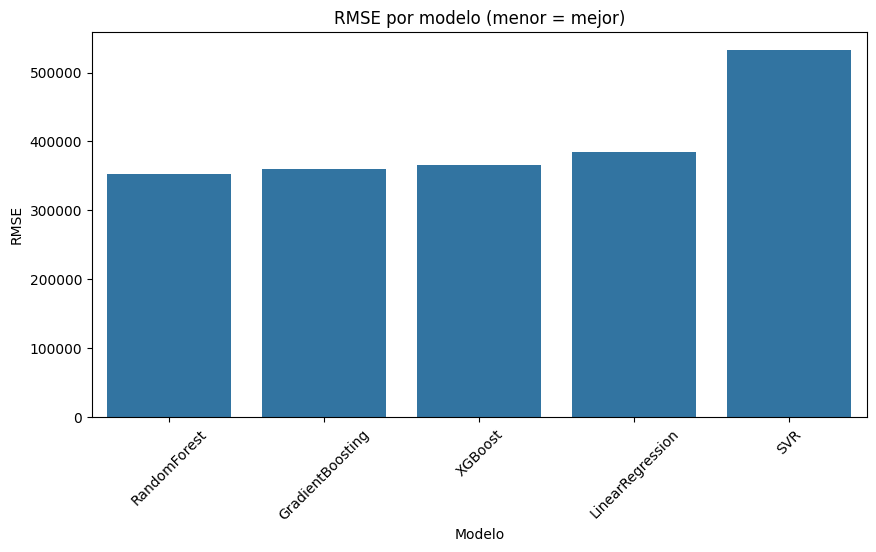

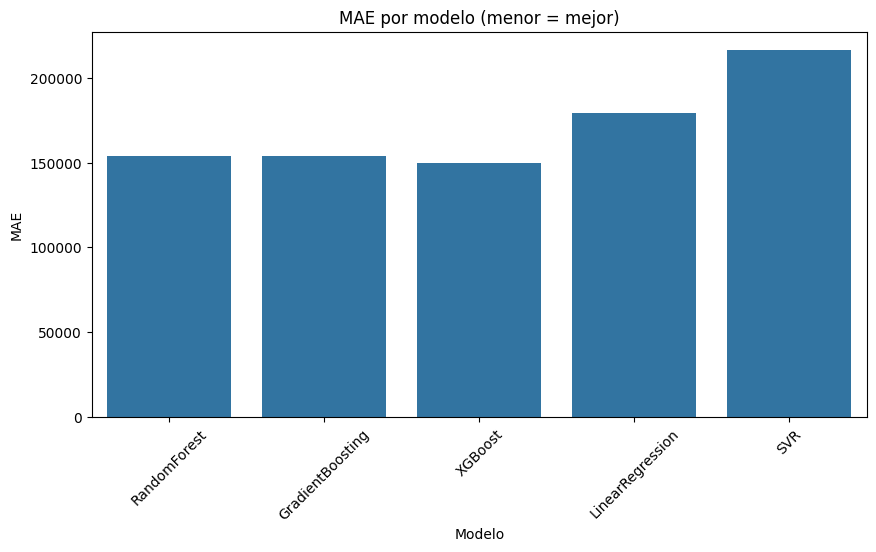

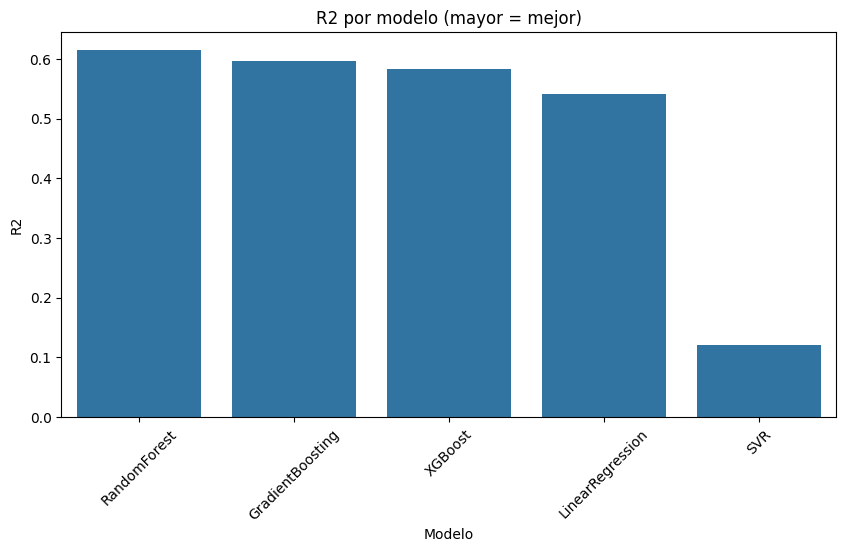

In [42]:
#visualizacion en greficas
plt.figure(figsize=(10,5))
sns.barplot(data=df_results, x="Modelo", y="RMSE")
plt.title("RMSE por modelo (menor = mejor)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=df_results, x="Modelo", y="MAE")
plt.title("MAE por modelo (menor = mejor)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=df_results, x="Modelo", y="R2")
plt.title("R2 por modelo (mayor = mejor)")
plt.xticks(rotation=45)
plt.show()


<Axes: >

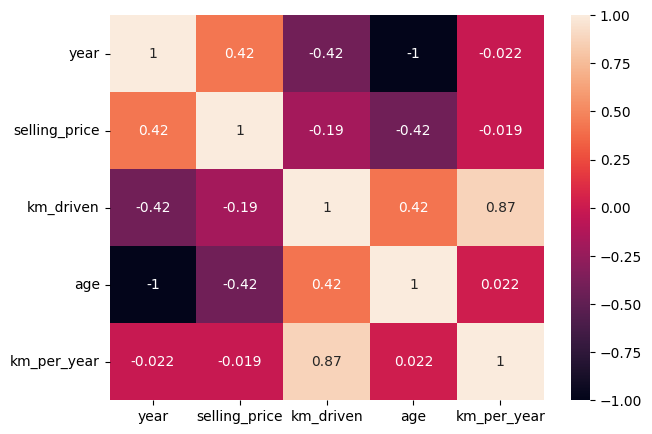

In [19]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [21]:
from sklearn.cluster import KMeans
cluster_df = df[['km_driven', 'age', 'km_per_year', 'selling_price']]
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_df)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(cluster_scaled)
df['cluster'] = clusters


---

In [22]:
df.groupby('cluster')[['selling_price','km_driven','age','km_per_year']].median()


,selling_price,km_driven,age,km_per_year
cluster,,,,
0,400000.0,120000.0,12.0,10000.000000
1,180000.0,74510.0,15.0,5000.000000
2,550000.0,35000.0,8.0,3922.607955


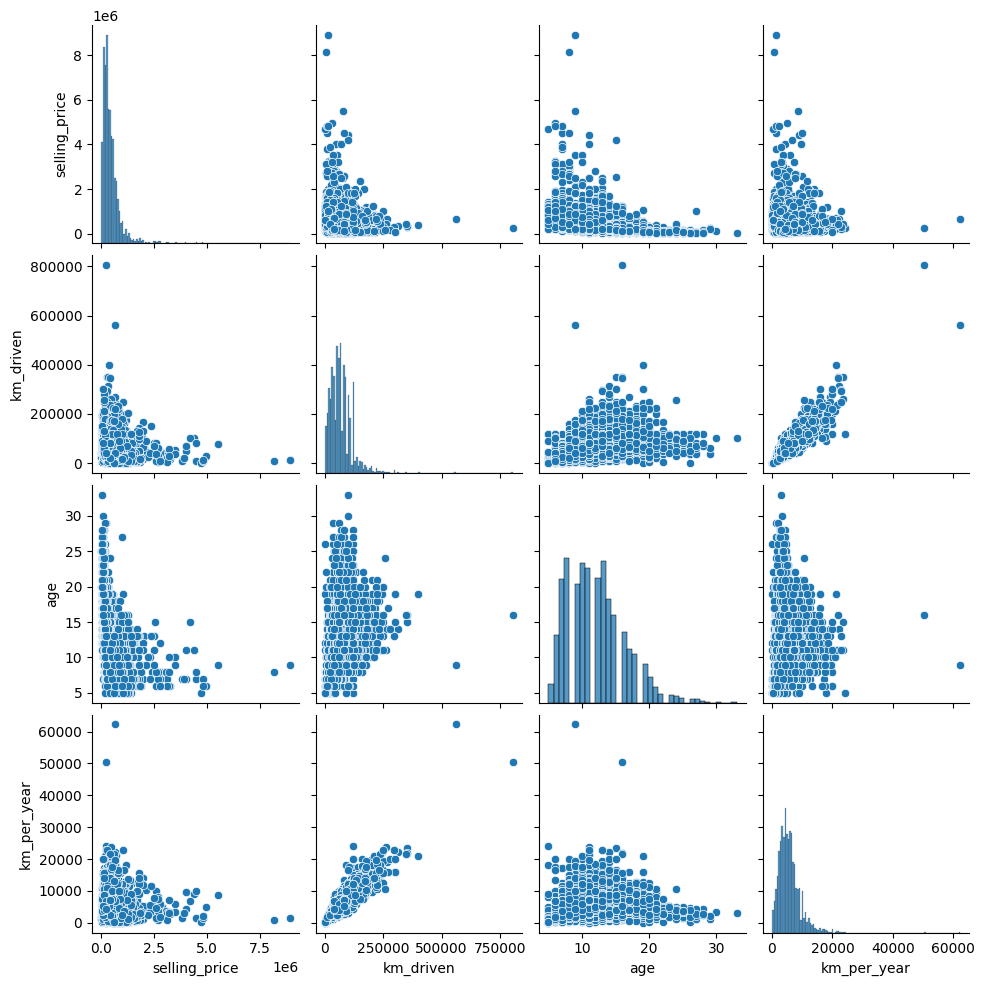

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df[['selling_price', 'km_driven', 'age', 'km_per_year']])
plt.show()
